# E-Commerce Delivery EDA (SQL → Python)

In this notebook, I’m analyzing the **Gold feature view** I built in SQL Server.  
My goal is to understand **late delivery behavior**, identify **drivers** (time, state, category, shipping stages), and produce insights that can feed a dashboard and a machine learning model.

## Notebook structure

1. Load data from SQL (Gold feature view)  
2. Quick validation + missingness  
3. Class balance (late vs on-time)  
4. Distribution checks + outliers  
5. Time trends (month/day)  
6. Segment analysis (state, category)  
7. Data cleaning for modeling  
8. Baseline model + evaluation (PR curve, threshold tuning)  
9. Multi-model comparison + recommendation

## 1) Setup

I start by importing the libraries I’ll use for exploration and plotting.


In [1]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install pymssql

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymssql

In [12]:
import pandas as pd
import pymssql

query = "SELECT * FROM gold.vw_order_delivery_features_v4;"  # <-- your view

conn = pymssql.connect(
    server=r"127.0.0.1",   # or "127.0.0.1"
    port=1433,
    user="pratishtha",              # or omit user/pw if you use Windows auth (see below)
    password="Pratishtha22@",
    database="ECommerceDB"                    # <-- your Olist database name
)

df = pd.read_sql(query, conn)
conn.close()

df.head()

C:\Users\prati\AppData\Local\Temp\ipykernel_8996\3776279237.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,order_id,customer_id,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,is_late,days_to_deliver,days_to_ship,days_carrier_to_customer,...,review_rows,avg_review_score,max_review_score,delay_days,late_days,purchase_weekday,purchase_weekday_num,purchase_month,purchase_year,top_category
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,0,7,6.0,1.0,...,1.0,5.0,5.0,-9,0,Wednesday,4,9,2017,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,0,16,8.0,8.0,...,1.0,4.0,4.0,-3,0,Wednesday,4,4,2017,pet_shop
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,0,8,2.0,6.0,...,1.0,5.0,5.0,-14,0,Sunday,1,1,2018,moveis_decoracao
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,0,6,2.0,4.0,...,1.0,4.0,4.0,-6,0,Wednesday,4,8,2018,perfumaria
4,00048cc3ae777c65dbb7d2a0634bc1ea,816cbea969fe5b689b39cfc97a506742,2017-05-15 21:42:34,2017-05-17 11:05:55,2017-05-22 13:44:35,2017-06-06,0,7,2.0,5.0,...,1.0,4.0,4.0,-15,0,Monday,2,5,2017,utilidades_domesticas


## 2) Quick validation

First I check the shape, schema, missingness, and duplicate keys so I know what I’m dealing with before plotting anything.

In [14]:
df.shape

(96386, 30)

In [15]:
df.info()

# missingness
missing = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
missing[missing > 0].head(20)

# duplicates
df["order_id"].duplicated().sum()

<class 'pandas.DataFrame'>
RangeIndex: 96386 entries, 0 to 96385
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96386 non-null  str           
 1   customer_id                    96386 non-null  str           
 2   order_purchase_timestamp       96386 non-null  datetime64[us]
 3   order_delivered_carrier_date   96385 non-null  datetime64[us]
 4   order_delivered_customer_date  96386 non-null  datetime64[us]
 5   order_estimated_delivery_date  96386 non-null  datetime64[us]
 6   is_late                        96386 non-null  int64         
 7   days_to_deliver                96386 non-null  int64         
 8   days_to_ship                   96385 non-null  float64       
 9   days_carrier_to_customer       96385 non-null  float64       
 10  customer_city                  96386 non-null  str           
 11  customer_state            

np.int64(0)

In [16]:
df["top_category"] = df["top_category"].fillna("Unknown")

In [17]:
dt_cols = [
    "order_purchase_timestamp",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]
for c in dt_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# sanity checks
(df["order_delivered_customer_date"] < df["order_purchase_timestamp"]).sum(), \
(df["order_delivered_customer_date"] < df["order_delivered_carrier_date"]).sum()

(np.int64(0), np.int64(0))

## 3) Target distribution (class imbalance)

Late delivery is the minority class, so accuracy alone will be misleading.  
I treat this as an *imbalanced classification* problem and rely more on **Precision–Recall** metrics and **lift**.

In [18]:
late_rate = df["is_late"].mean()
late_rate

np.float64(0.08117361442533148)

In [19]:
counts = df["is_late"].value_counts()
counts

is_late
0    88562
1     7824
Name: count, dtype: int64

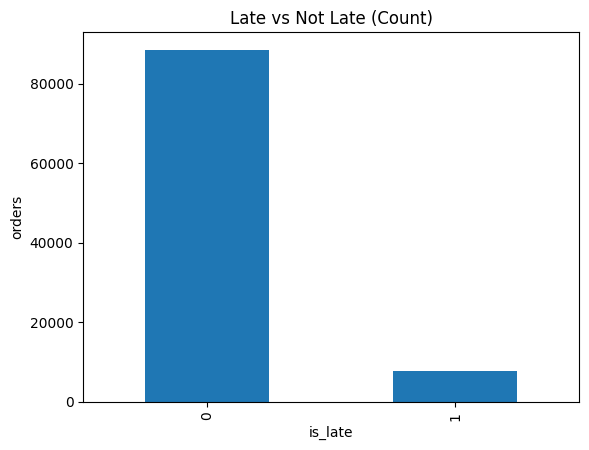

In [20]:
plt.figure()
counts.plot(kind="bar")
plt.title("Late vs Not Late (Count)")
plt.xlabel("is_late")
plt.ylabel("orders")
plt.show()

## 4) Numeric distributions + outliers

Here I examine shipping/delivery time features and monetary features to understand:
- typical ranges
- long tails / extreme values
- how late vs on-time differs in distribution


In [21]:
num_cols = ["days_to_deliver", "days_to_ship", "days_carrier_to_customer", "delay_days", "late_days", "total_price", "total_freight", "items_count"]

df[num_cols].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).T

,count,mean,std,min,50%,90%,95%,99%,max
days_to_deliver,96386.0,12.503538,9.555997,0.00,10.00,23.000000,29.000000,46.000000,210.000000
days_to_ship,96385.0,3.212865,3.609939,-171.00,2.00,6.000000,9.000000,18.000000,126.000000
days_carrier_to_customer,96385.0,9.290263,8.776415,0.00,7.00,19.000000,24.000000,41.000000,205.000000
delay_days,96386.0,-11.873560,10.181982,-147.00,-12.00,-2.000000,3.000000,18.000000,188.000000
late_days,96386.0,0.719928,4.654543,0.00,0.00,0.000000,3.000000,18.000000,188.000000
total_price,96386.0,137.048576,209.097554,0.85,86.50,269.000000,399.000000,990.000000,13440.000000
total_freight,96386.0,22.789155,21.563461,0.00,17.18,39.380001,54.799999,104.242999,1794.960022
items_count,96386.0,1.141971,0.538436,1.00,1.00,1.000000,2.000000,3.000000,21.000000


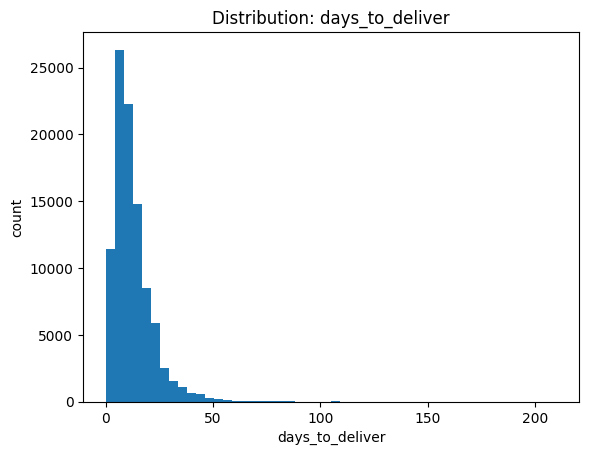

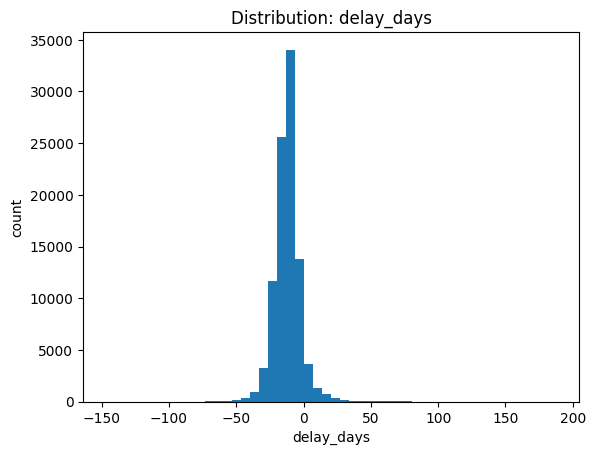

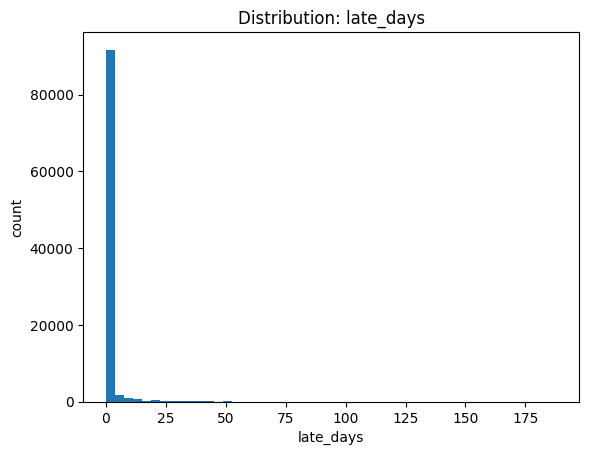

In [22]:
def hist(col, bins=50):
    plt.figure()
    df[col].dropna().plot(kind="hist", bins=bins)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

for c in ["days_to_deliver", "delay_days", "late_days"]:
    hist(c)

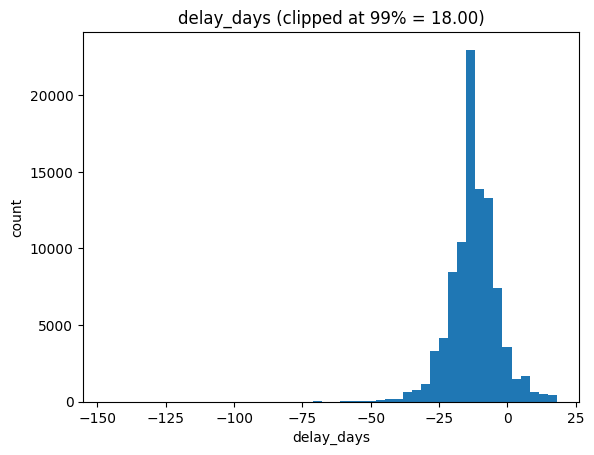

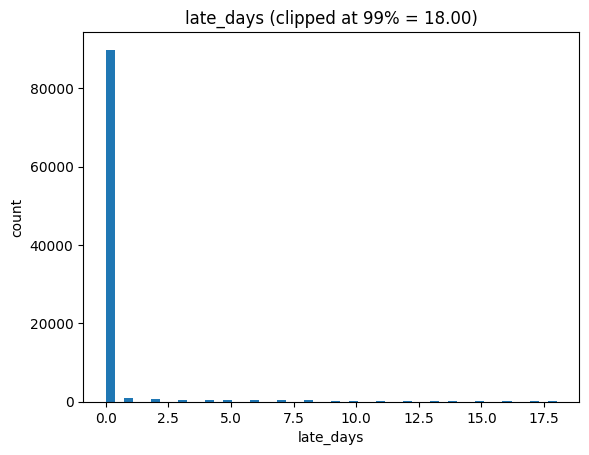

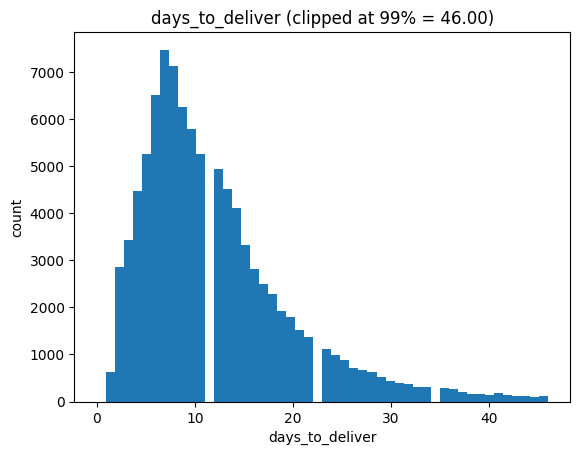

In [23]:
def hist_clip(col, q=0.99, bins=50):
    lim = df[col].quantile(q)
    plt.figure()
    df.loc[df[col] <= lim, col].dropna().plot(kind="hist", bins=bins)
    plt.title(f"{col} (clipped at {q:.0%} = {lim:.2f})")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

hist_clip("delay_days")
hist_clip("late_days")
hist_clip("days_to_deliver")

## 5) Time trends

I look at late rate and volume over time to see if there are seasonal patterns or periods with higher operational risk.


In [24]:
df["purchase_month_start"] = df["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()

monthly = df.groupby("purchase_month_start").agg(
    orders=("order_id", "count"),
    late_rate=("is_late", "mean"),
    avg_delay=("delay_days", "mean"),
    avg_days_to_deliver=("days_to_deliver", "mean"),
)

monthly.tail()

,orders,late_rate,avg_delay,avg_days_to_deliver
purchase_month_start,,,,
2018-04-01,6783,0.053221,-12.895621,11.437712
2018-05-01,6749,0.082383,-12.190991,11.336494
2018-06-01,6094,0.013620,-19.244831,9.165901
2018-07-01,6130,0.045024,-11.450571,8.913866
2018-08-01,6345,0.103704,-8.165642,7.659417


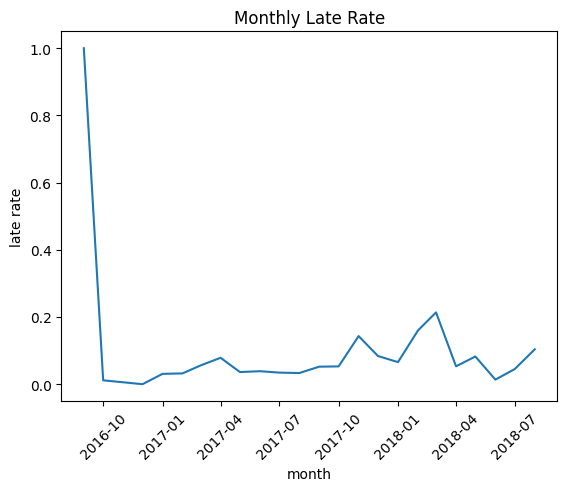

In [25]:
plt.figure()
plt.plot(monthly.index, monthly["late_rate"])
plt.title("Monthly Late Rate")
plt.xlabel("month")
plt.ylabel("late rate")
plt.xticks(rotation=45)
plt.show()

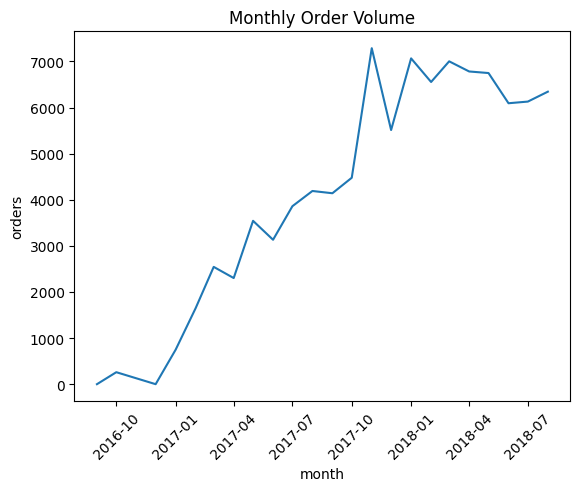

In [26]:
plt.figure()
plt.plot(monthly.index, monthly["orders"])
plt.title("Monthly Order Volume")
plt.xlabel("month")
plt.ylabel("orders")
plt.xticks(rotation=45)
plt.show()

## 6) Segment analysis (state & category)

I group by **customer_state** and **top_category** (with a minimum sample size) to identify:
- where late deliveries cluster
- which segments have the highest risk

In [27]:
MIN_N = 200

state_stats = df.groupby("customer_state").agg(
    orders=("order_id", "count"),
    late_rate=("is_late", "mean"),
    avg_late_days=("late_days", "mean")
).query("orders >= @MIN_N").sort_values("late_rate", ascending=False)

state_stats.head(15)

,orders,late_rate,avg_late_days
customer_state,,,
AL,397,0.239295,2.042821
MA,717,0.196653,1.831241
PI,476,0.159664,1.850840
CE,1278,0.153365,2.090767
SE,335,0.152239,2.465672
BA,3256,0.140356,1.462224
RJ,12347,0.134770,1.637321
TO,274,0.127737,0.642336
PA,946,0.123679,1.436575


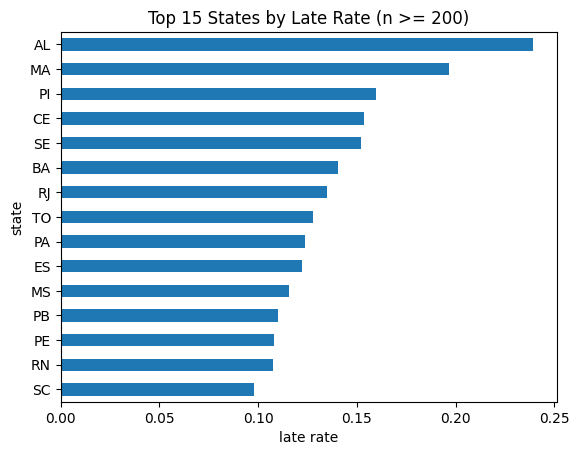

In [28]:
plt.figure()
state_stats.head(15)["late_rate"].sort_values().plot(kind="barh")
plt.title(f"Top 15 States by Late Rate (n >= {MIN_N})")
plt.xlabel("late rate")
plt.ylabel("state")
plt.show()

In [29]:
cat_stats = df.groupby("top_category").agg(
    orders=("order_id", "count"),
    late_rate=("is_late", "mean"),
    avg_late_days=("late_days", "mean")
).query("orders >= @MIN_N").sort_values("late_rate", ascending=False)

cat_stats.head(15)

,orders,late_rate,avg_late_days
top_category,,,
audio,348,0.129310,0.991379
livros_tecnicos,252,0.111111,0.543651
casa_conforto,346,0.109827,1.372832
alimentos,439,0.100228,0.986333
eletronicos,2508,0.098485,0.714514
construcao_ferramentas_iluminacao,236,0.093220,0.406780
bebes,2788,0.092539,0.928623
moveis_escritorio,1244,0.092444,1.072347
construcao_ferramentas_construcao,728,0.092033,0.887363


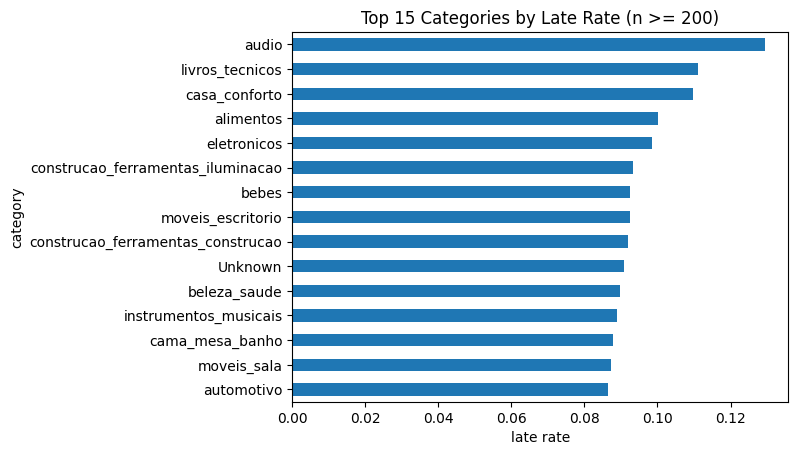

In [30]:
plt.figure()
cat_stats.head(15)["late_rate"].sort_values().plot(kind="barh")
plt.title(f"Top 15 Categories by Late Rate (n >= {MIN_N})")
plt.xlabel("late rate")
plt.ylabel("category")
plt.show()

<Figure size 640x480 with 0 Axes>

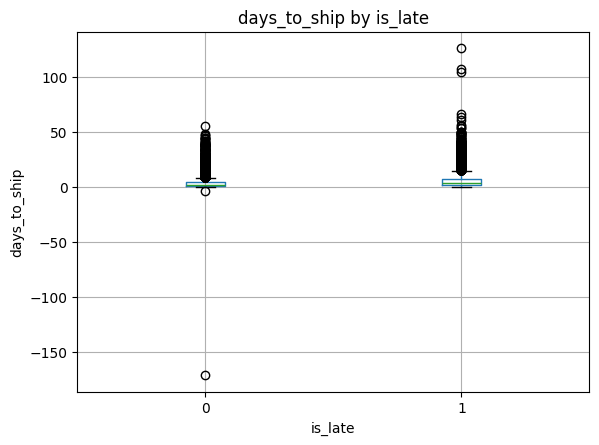

<Figure size 640x480 with 0 Axes>

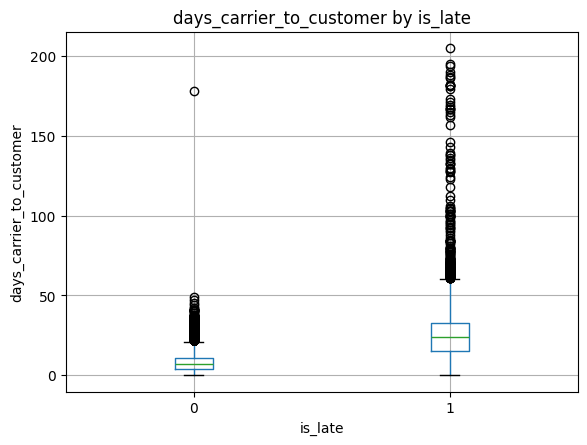

<Figure size 640x480 with 0 Axes>

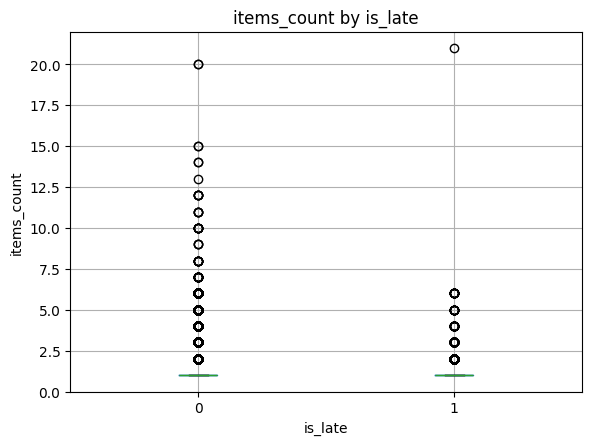

<Figure size 640x480 with 0 Axes>

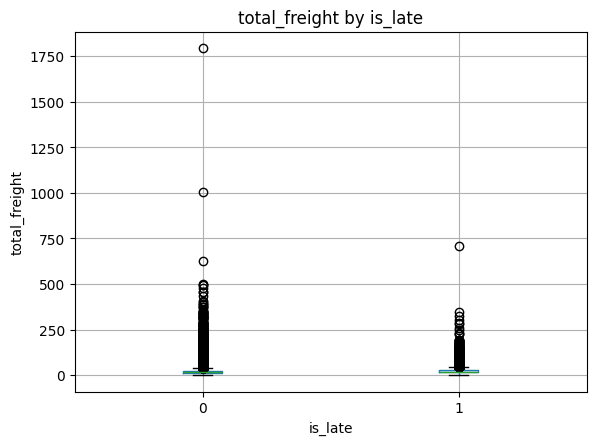

<Figure size 640x480 with 0 Axes>

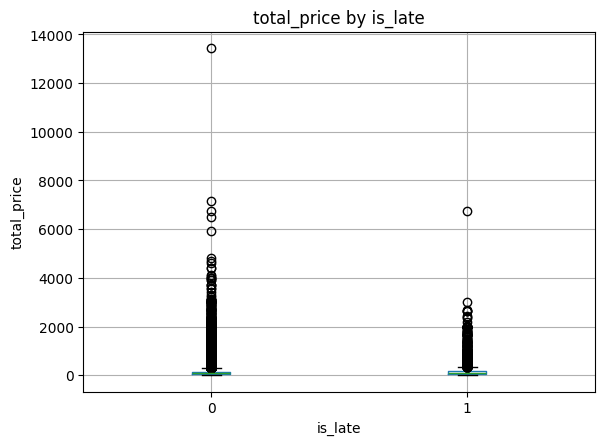

In [31]:
def box_by_target(col):
    plt.figure()
    df.boxplot(column=col, by="is_late")
    plt.title(f"{col} by is_late")
    plt.suptitle("")
    plt.xlabel("is_late")
    plt.ylabel(col)
    plt.show()

for c in ["days_to_ship", "days_carrier_to_customer", "items_count", "total_freight", "total_price"]:
    box_by_target(c)

In [32]:
numeric = df.select_dtypes(include=[np.number])
corr = numeric.corr(numeric_only=True)["is_late"].sort_values(ascending=False)
corr.head(15)

is_late                     1.000000
delay_days                  0.605512
days_to_deliver             0.590350
days_carrier_to_customer    0.554664
late_days                   0.520384
days_to_ship                0.213966
purchase_year               0.051262
total_freight               0.025252
total_payment_value         0.017438
total_price                 0.015653
max_installments            0.009063
review_rows                -0.001710
payment_rows               -0.004805
purchase_weekday_num       -0.005718
items_count                -0.015789
Name: is_late, dtype: float64

In [33]:
summary = {
    "rows": len(df),
    "late_rate": df["is_late"].mean(),
    "avg_days_to_deliver": df["days_to_deliver"].mean(),
    "avg_delay_days": df["delay_days"].mean(),
    "p95_delay_days": df["delay_days"].quantile(0.95),
    "missing_top_category": (df["top_category"] == "Unknown").sum()
}
summary

{'rows': 96386,
 'late_rate': np.float64(0.08117361442533148),
 'avg_days_to_deliver': np.float64(12.503537858195173),
 'avg_delay_days': np.float64(-11.873560475587741),
 'p95_delay_days': np.float64(3.0),
 'missing_top_category': np.int64(1378)}

In [34]:
time_cols = ["days_to_ship", "days_to_deliver", "days_carrier_to_customer"]
for c in time_cols:
    print(c, (df[c] < 0).sum())

df["flag_negative_ship"] = (df["days_to_ship"] < 0).astype(int)
df["flag_negative_deliver"] = (df["days_to_deliver"] < 0).astype(int)
df["flag_negative_carrier_to_customer"] = (df["days_carrier_to_customer"] < 0).astype(int)

df[["flag_negative_ship","flag_negative_deliver","flag_negative_carrier_to_customer"]].mean()

days_to_ship 2
days_to_deliver 0
days_carrier_to_customer 0


flag_negative_ship                   0.000021
flag_negative_deliver                0.000000
flag_negative_carrier_to_customer    0.000000
dtype: float64

## 7) Data cleaning for modeling

Before training any models, I remove obviously invalid timing rows (e.g., negative durations).  
I keep the cleaning minimal so results remain comparable to the SQL view.

In [35]:
df_clean = df.copy()

# drop impossible negatives for core timing features
for c in ["days_to_ship", "days_to_deliver", "days_carrier_to_customer"]:
    df_clean = df_clean[df_clean[c].isna() | (df_clean[c] >= 0)]

df_clean.shape

(96384, 34)

In [36]:
def cap_series(s, lo=0.01, hi=0.99):
    low, high = s.quantile(lo), s.quantile(hi)
    return s.clip(low, high)

cap_cols = ["delay_days", "late_days", "days_to_deliver", "days_to_ship",
            "days_carrier_to_customer", "total_price", "total_freight", "items_count"]

for c in cap_cols:
    if c in df_clean.columns:
        df_clean[c] = cap_series(df_clean[c])

df_clean[cap_cols].describe(percentiles=[0.01, 0.5, 0.99]).T

,count,mean,std,min,1%,50%,99%,max
delay_days,96384.0,-11.970524,8.913487,-36.00,-36.00,-12.00,18.000000,18.000000
late_days,96384.0,0.551544,2.557507,0.00,0.00,0.00,18.000000,18.000000
days_to_deliver,96384.0,12.344819,8.413249,2.00,2.00,10.00,46.000000,46.000000
days_to_ship,96383.0,3.142868,3.041670,0.00,0.00,2.00,18.000000,18.000000
days_carrier_to_customer,96383.0,9.130573,7.571490,1.00,1.00,7.00,41.000000,41.000000
total_price,96384.0,131.174295,154.591645,11.99,11.99,86.50,990.000000,990.000000
total_freight,96384.0,22.253232,16.215258,7.39,7.39,17.18,104.240576,104.243399
items_count,96384.0,1.122915,0.392743,1.00,1.00,1.00,3.000000,3.000000


## 8) Train/test split (time-aware)

I split chronologically (first 80% for training, last 20% for testing) to mimic a real forecasting setup and avoid leakage.


In [37]:
df_clean["purchase_month"] = df_clean["order_purchase_timestamp"].dt.month
df_clean["purchase_year"] = df_clean["order_purchase_timestamp"].dt.year
df_clean["purchase_weekday_num"] = df_clean["order_purchase_timestamp"].dt.weekday  # 0=Mon

# target
y = df_clean["is_late"].astype(int)

# features to use (keep it simple for baseline)
feature_cols = [
    "days_to_ship",
    "days_carrier_to_customer",
    "days_to_deliver",
    "items_count",
    "total_price",
    "total_freight",
    "purchase_month",
    "purchase_weekday_num",
    "customer_state",
    "top_category",
]

X = df_clean[feature_cols].copy()
X.head()

,days_to_ship,days_carrier_to_customer,days_to_deliver,items_count,total_price,total_freight,purchase_month,purchase_weekday_num,customer_state,top_category
0,6.0,1.0,7,1,58.900002,13.290000,9,2,RJ,cool_stuff
1,8.0,8.0,16,1,239.899994,19.930000,4,2,SP,pet_shop
2,2.0,6.0,8,1,199.000000,17.870001,1,6,MG,moveis_decoracao
3,2.0,4.0,6,1,12.990000,12.790000,8,2,SP,perfumaria
4,2.0,5.0,7,1,21.900000,12.690000,5,0,MG,utilidades_domesticas


In [38]:
df_clean = df_clean.sort_values("order_purchase_timestamp").reset_index(drop=True)

split_idx = int(len(df_clean) * 0.80)
train_df = df_clean.iloc[:split_idx]
test_df  = df_clean.iloc[split_idx:]

X_train = train_df[feature_cols].copy()
y_train = train_df["is_late"].astype(int)

X_test = test_df[feature_cols].copy()
y_test = test_df["is_late"].astype(int)

train_df["order_purchase_timestamp"].min(), train_df["order_purchase_timestamp"].max(), \
test_df["order_purchase_timestamp"].min(), test_df["order_purchase_timestamp"].max()

(Timestamp('2016-09-15 12:16:38'),
 Timestamp('2018-05-26 14:19:39'),
 Timestamp('2018-05-26 14:29:06'),
 Timestamp('2018-08-29 15:00:37'))

In [39]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------ --------------------- 3.7/8.1 MB 25.4 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 27.5 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 20.0 MB/s  0:00:00
   ---------------------------------------- 0.0/37.3 MB ? eta -:--:--
   ------- -------------------------------- 6.6/37.3 MB 32.6 MB/s eta 0:00:01
   ------------- -------------------------- 12.6/37.3 MB 28.9 MB/s eta 0:00:01
   ----------------- ---------------------- 16.3/37.3 MB 25.0 MB/s eta 0:00:01
   ------------------------- -------------- 23.3/37.3 MB 26.3 MB/s eta 0:00:01
   ------------------------------ --------- 28.8/37.3 MB 25.8 MB/s eta 0:00:01
   ------------------------------------ --- 34.1/37.3 MB 25.5 MB/s eta 0:00:01
   ---------------------------------------  37.2/37.3 MB 25.3 MB/s eta 0:00:01
   ---------------------------------------  37.2/37.3 MB 25.3 MB/s eta 0:00:01
  

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

num_features = [c for c in feature_cols if c not in ["customer_state", "top_category"]]
cat_features = ["customer_state", "top_category"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features),
    ]
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred, digits=3))

C:\Users\prati\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC: 0.8366496367462726
              precision    recall  f1-score   support

           0      0.962     0.982     0.972     18258
           1      0.484     0.305     0.374      1019

    accuracy                          0.946     19277
   macro avg      0.723     0.644     0.673     19277
weighted avg      0.937     0.946     0.940     19277



### Baseline evaluation: PR curve

Precision–Recall is more informative than ROC for imbalanced datasets.  
I compute **PR-AUC** and later tune the threshold for a target recall.


In [41]:
precision, recall, _ = precision_recall_curve(y_test, proba)
pr_auc = auc(recall, precision)
pr_auc

0.37791136711420226

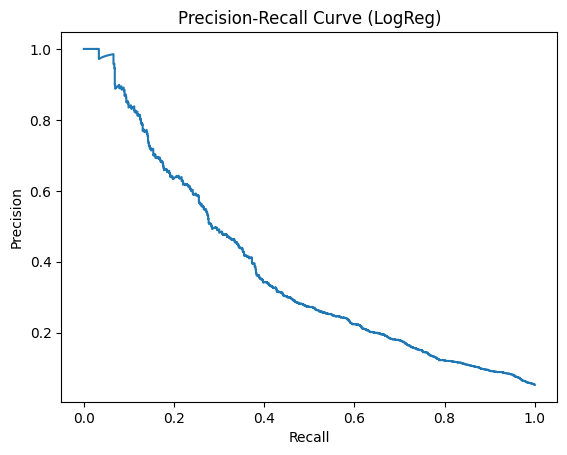

In [42]:
plt.figure()
plt.plot(recall, precision)
plt.title("Precision-Recall Curve (LogReg)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

### Threshold tuning (operational decision)

Instead of using 0.50, I pick a threshold that hits a target recall (example: 50–60%).  
This makes the model usable for triage workflows (flag top risk orders).


In [43]:
target_recall = 0.50
idx = np.argmin(np.abs(recall - target_recall))
best_threshold = _[max(idx-1, 0)] if len(_) > 0 else 0.5
best_threshold

np.float64(0.09755150990563873)

In [44]:
pred2 = (proba >= best_threshold).astype(int)
print("Threshold:", best_threshold)
print(classification_report(y_test, pred2, digits=3))

Threshold: 0.09755150990563873
              precision    recall  f1-score   support

           0      0.971     0.925     0.948     18258
           1      0.273     0.501     0.353      1019

    accuracy                          0.903     19277
   macro avg      0.622     0.713     0.650     19277
weighted avg      0.934     0.903     0.916     19277



In [45]:
# Pull names out of the preprocessing pipeline
ohe = clf.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_names = ohe.get_feature_names_out(cat_features)

feature_names = np.concatenate([num_features, cat_names])
coefs = clf.named_steps["model"].coef_[0]

imp = pd.DataFrame({"feature": feature_names, "coef": coefs})
imp["abs_coef"] = imp["coef"].abs()
imp.sort_values("abs_coef", ascending=False).head(20)

,feature,coef,abs_coef
10,customer_state_AM,-5.445840,5.445840
33,customer_state_SP,3.468506,3.468506
28,customer_state_RO,-3.466682,3.466682
21,customer_state_PA,-3.267337,3.267337
11,customer_state_AP,-2.369861,2.369861
22,customer_state_PB,-2.281424,2.281424
91,top_category_moveis_escritorio,-1.889604,1.889604
8,customer_state_AC,-1.772950,1.772950
18,customer_state_MG,1.765225,1.765225
79,top_category_industria_comercio_e_negocios,1.740397,1.740397


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

In [62]:
num_features = [c for c in feature_cols if c not in ["customer_state", "top_category"]]
cat_features = ["customer_state", "top_category"]

preprocess_scaled = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features),
    ]
)

preprocess_noscale = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features),
    ]
)

In [63]:
def pick_threshold_for_recall(y_true, proba, target_recall=0.60):
    precision, recall, thresholds = precision_recall_curve(y_true, proba)
    # thresholds length = len(precision)-1
    # choose the highest threshold that still meets target recall (more conservative)
    valid = np.where(recall[:-1] >= target_recall)[0]
    if len(valid) == 0:
        return 0.5, precision, recall, thresholds
    idx = valid[-1]
    return thresholds[idx], precision, recall, thresholds

def eval_model(name, pipe, X_train, y_train, X_test, y_test, target_recall=0.60):
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]

    roc = roc_auc_score(y_test, proba)
    prec, rec, _ = precision_recall_curve(y_test, proba)
    pr_auc = auc(rec, prec)

    thr, prec_curve, rec_curve, thr_curve = pick_threshold_for_recall(y_test, proba, target_recall)
    pred = (proba >= thr).astype(int)

    cm = confusion_matrix(y_test, pred)
    tn, fp, fn, tp = cm.ravel()

    caught = tp
    total_late = tp + fn
    caught_pct = caught / total_late if total_late else 0.0

    return {
        "model": name,
        "roc_auc": roc,
        "pr_auc": pr_auc,
        "threshold_for_recall": thr,
        "late_recall": tp / (tp + fn) if (tp + fn) else 0.0,
        "late_precision": tp / (tp + fp) if (tp + fp) else 0.0,
        "late_caught": caught,
        "late_total": total_late,
        "late_caught_pct": caught_pct,
        "false_alarms": fp,
        "pipe": pipe,
        "proba": proba,
        "pr_curve": (prec_curve, rec_curve)
    }

In [68]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# same num/cat feature lists
num_features = [c for c in feature_cols if c not in ["customer_state","top_category"]]
cat_features = ["customer_state","top_category"]

# this makes one-hot output DENSE
preprocess_dense = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_features),
    ]
)

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

models = [
    ("LogReg (balanced)",
     Pipeline(steps=[
         ("prep", preprocess_scaled),
         ("model", LogisticRegression(max_iter=4000, class_weight="balanced", solver="lbfgs"))
     ])
    ),

    ("RandomForest (balanced_subsample)",
     Pipeline(steps=[
         ("prep", preprocess_noscale),
         ("model", RandomForestClassifier(
             n_estimators=400,
             min_samples_leaf=10,
             class_weight="balanced_subsample",
             n_jobs=-1,
             random_state=42
         ))
     ])
    ),

    ("GradientBoosting",
     Pipeline(steps=[
         ("prep", preprocess_noscale),
         ("model", GradientBoostingClassifier(random_state=42))
     ])
    ),

    ("HistGradientBoosting (dense OHE)",
     Pipeline(steps=[
         ("prep", preprocess_dense),
         ("model", HistGradientBoostingClassifier(
             max_depth=6,
             learning_rate=0.08,
             max_iter=300,
             random_state=42
         ))
     ])
    ),
]

## 11) Compare multiple models + tradeoffs

Now I compare a small set of models and report:
- ROC-AUC and PR-AUC
- threshold that achieves my target recall
- how many late orders are caught vs. how many false alarms


In [70]:
TARGET_RECALL = 0.60
results = []

for name, pipe in models:
    out = eval_model(name, pipe, X_train, y_train, X_test, y_test, target_recall=TARGET_RECALL)
    results.append({k: out[k] for k in [
        "model","roc_auc","pr_auc","threshold_for_recall",
        "late_recall","late_precision","late_caught","late_total","late_caught_pct","false_alarms"
    ]})

results_df = pd.DataFrame(results).sort_values(["pr_auc","roc_auc"], ascending=False)
results_df

,model,roc_auc,pr_auc,threshold_for_recall,late_recall,late_precision,late_caught,late_total,late_caught_pct,false_alarms
3,HistGradientBoosting (dense OHE),0.799215,0.388480,0.004832,0.600589,0.239249,612,1019,0.600589,1946
0,LogReg (balanced),0.837242,0.378097,0.054029,0.600589,0.225248,612,1019,0.600589,2105
2,GradientBoosting,0.840109,0.368920,0.008209,0.658489,0.181548,671,1019,0.658489,3025
1,RandomForest (balanced_subsample),0.817340,0.356273,0.072948,0.600589,0.205369,612,1019,0.600589,2368


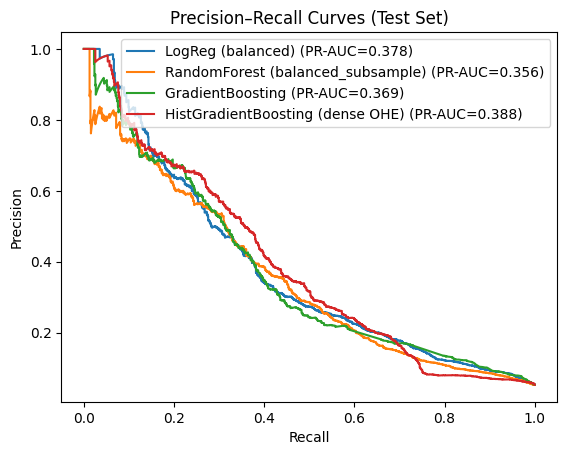

In [71]:
plt.figure()
for name, pipe in models:
    out = eval_model(name, pipe, X_train, y_train, X_test, y_test, target_recall=TARGET_RECALL)
    p, r = out["pr_curve"]
    plt.plot(r, p, label=f"{name} (PR-AUC={out['pr_auc']:.3f})")

plt.title("Precision–Recall Curves (Test Set)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [72]:
best_name = results_df.iloc[0]["model"]
best_pipe = None
for name, pipe in models:
    if name == best_name:
        best_pipe = pipe
        break

best_out = eval_model(best_name, best_pipe, X_train, y_train, X_test, y_test, target_recall=TARGET_RECALL)

print("Best model:", best_out["model"])
print("ROC-AUC:", best_out["roc_auc"])
print("PR-AUC:", best_out["pr_auc"])
print("Chosen threshold for recall≥", TARGET_RECALL, ":", best_out["threshold_for_recall"])
print("Late recall:", best_out["late_recall"])
print("Late precision:", best_out["late_precision"])
print(f"Late caught: {best_out['late_caught']} / {best_out['late_total']} ({best_out['late_caught_pct']:.1%})")
print("False alarms:", best_out["false_alarms"])

pred_best = (best_out["proba"] >= best_out["threshold_for_recall"]).astype(int)
print("\nConfusion matrix [ [TN FP] [FN TP] ]:\n", confusion_matrix(y_test, pred_best))
print("\nClassification report:\n", classification_report(y_test, pred_best, digits=3))

Best model: HistGradientBoosting (dense OHE)
ROC-AUC: 0.7992154164531478
PR-AUC: 0.38848028667492523
Chosen threshold for recall≥ 0.6 : 0.00483230873130562
Late recall: 0.6005888125613347
Late precision: 0.23924941360437843
Late caught: 612 / 1019 (60.1%)
False alarms: 1946

Confusion matrix [ [TN FP] [FN TP] ]:
 [[16312  1946]
 [  407   612]]

Classification report:
               precision    recall  f1-score   support

           0      0.976     0.893     0.933     18258
           1      0.239     0.601     0.342      1019

    accuracy                          0.878     19277
   macro avg      0.607     0.747     0.637     19277
weighted avg      0.937     0.878     0.902     19277



In [74]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report

TARGET_RECALL = 0.60
sample_w = compute_sample_weight(class_weight="balanced", y=y_train)

hgb = Pipeline(steps=[
    ("prep", preprocess_dense),   # ✅ DENSE one-hot
    ("model", HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.08,
        max_iter=300,
        random_state=42
    ))
])

# pass weights to the final estimator
hgb.fit(X_train, y_train, model__sample_weight=sample_w)

proba = hgb.predict_proba(X_test)[:, 1]

# PR-AUC + ROC-AUC
precision, recall, thresholds = precision_recall_curve(y_test, proba)
pr_auc = auc(recall, precision)
roc = roc_auc_score(y_test, proba)

print("ROC-AUC:", roc)
print("PR-AUC:", pr_auc)

# pick threshold to hit recall >= target
valid = np.where(recall[:-1] >= TARGET_RECALL)[0]
thr = thresholds[valid[-1]] if len(valid) else 0.5
pred = (proba >= thr).astype(int)

print("Chosen threshold:", thr)
print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print(classification_report(y_test, pred, digits=3))

ROC-AUC: 0.8110102111798276
PR-AUC: 0.39901876442447687
Chosen threshold: 0.027107974133848575
Confusion matrix:
 [[16436  1822]
 [  407   612]]
              precision    recall  f1-score   support

           0      0.976     0.900     0.936     18258
           1      0.251     0.601     0.354      1019

    accuracy                          0.884     19277
   macro avg      0.614     0.750     0.645     19277
weighted avg      0.938     0.884     0.906     19277



In [76]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc

# -----------------------------
# Helpers
# -----------------------------
def missing_rate(series):
    return float(series.isna().mean())

def recall_precision_lift_at_k(y_true, proba, k=0.10):
    """
    Compute Recall@K, Precision@K, Lift@K where K is top k fraction by risk score.
    Lift@K = Precision@K / BaseRate
    """
    y_true = np.asarray(y_true).astype(int)
    proba = np.asarray(proba)

    n = len(y_true)
    top_n = max(1, int(np.ceil(n * k)))
    idx = np.argsort(proba)[::-1][:top_n]

    base_rate = y_true.mean() if y_true.mean() > 0 else 1e-9
    precision_k = y_true[idx].mean()
    recall_k = y_true[idx].sum() / max(1, y_true.sum())
    lift_k = precision_k / base_rate

    return recall_k, precision_k, lift_k, top_n, base_rate

def compute_pr_auc(y_true, proba):
    p, r, _ = precision_recall_curve(y_true, proba)
    return auc(r, p)

def safe_has_cols(df, cols):
    return all(c in df.columns for c in cols)

# -----------------------------
# Candidate questions
# -----------------------------
# You can add/remove questions later
questions = [
    {
        "question_id": "Q1",
        "title": "Predict late delivery risk (classification)",
        "type": "ml",
        "target": "is_late",
        "required_cols": ["is_late", "order_purchase_timestamp"],
        "recommended_features": [
            # keep these conservative & mostly pre-delivery available
            "customer_state", "top_category",
            "items_count", "total_price", "total_freight",
            "purchase_month", "purchase_weekday_num",
            "days_to_ship", "days_carrier_to_customer"  # WARNING: only if available pre-delivery in your use case
        ],
        "leakage_cols": ["avg_review_score", "max_review_score", "review_rows", "delay_days", "late_days", "days_to_deliver"],
        "actionability": 5  # 1-5 subjective, but grounded (can drive ops list + BI)
    },
    {
        "question_id": "Q2",
        "title": "Where are delays happening in the pipeline (stage analysis)?",
        "type": "diagnostic",
        "required_cols": ["days_to_ship", "days_carrier_to_customer", "days_to_deliver", "is_late"],
        "actionability": 4
    },
    {
        "question_id": "Q3",
        "title": "Which segments (state/category/time) have the highest late rates?",
        "type": "diagnostic",
        "required_cols": ["is_late", "customer_state", "top_category", "purchase_month", "purchase_year"],
        "actionability": 5
    },
    {
        "question_id": "Q4",
        "title": "Do late deliveries correlate with worse review scores?",
        "type": "diagnostic",
        "required_cols": ["is_late", "avg_review_score"],
        "actionability": 3
    },
    {
        "question_id": "Q5",
        "title": "What drives late severity (how many days late)?",
        "type": "ml_regression",
        "required_cols": ["late_days", "order_purchase_timestamp"],
        "actionability": 4
    },
]

# -----------------------------
# Pre-clean (minimal)
# -----------------------------
df_eval = df.copy()
if "top_category" in df_eval.columns:
    df_eval["top_category"] = df_eval["top_category"].fillna("Unknown")

# Ensure timestamps exist if present
if "order_purchase_timestamp" in df_eval.columns:
    df_eval["order_purchase_timestamp"] = pd.to_datetime(df_eval["order_purchase_timestamp"], errors="coerce")

# Create fallback time features if missing but timestamp exists
if "order_purchase_timestamp" in df_eval.columns:
    if "purchase_month" not in df_eval.columns:
        df_eval["purchase_month"] = df_eval["order_purchase_timestamp"].dt.month
    if "purchase_year" not in df_eval.columns:
        df_eval["purchase_year"] = df_eval["order_purchase_timestamp"].dt.year
    if "purchase_weekday_num" not in df_eval.columns:
        df_eval["purchase_weekday_num"] = df_eval["order_purchase_timestamp"].dt.weekday

# -----------------------------
# Scoring logic
# -----------------------------
rows = []

for q in questions:
    qid = q["question_id"]
    title = q["title"]
    qtype = q["type"]

    required_cols = q.get("required_cols", [])
    has_required = safe_has_cols(df_eval, required_cols)

    # Feasibility score (0-5)
    feasibility = 5 if has_required else max(0, 5 - int(5 * (1 - sum([c in df_eval.columns for c in required_cols]) / max(1, len(required_cols)))))

    # Data readiness: based on missingness of required columns
    if has_required:
        miss = np.mean([missing_rate(df_eval[c]) for c in required_cols])
        # map missingness -> readiness (0-5)
        readiness = float(np.clip(5 * (1 - miss), 0, 5))
    else:
        readiness = 0.0

    # Leakage risk (0-5): higher = safer
    leakage_cols = q.get("leakage_cols", [])
    leakage_present = [c for c in leakage_cols if c in df_eval.columns]
    if qtype == "ml":
        # if leakage cols exist, risk increases unless we exclude them
        # score is lower if many leakage columns exist in table (because temptation/leakage risk),
        # but we still can avoid them. We'll score moderately.
        leakage_safety = float(np.clip(5 - 0.5 * len(leakage_present), 0, 5))
    else:
        # for descriptive questions, leakage is not the same issue
        leakage_safety = 5.0

    predictability = np.nan
    recall10 = np.nan
    precision10 = np.nan
    lift10 = np.nan

    # For ML question, run a quick baseline model (LogReg balanced) with time split if possible
    if qtype == "ml" and has_required and "is_late" in df_eval.columns:
        # build feature list: include only columns that exist
        feat = [c for c in q["recommended_features"] if c in df_eval.columns]

        # IMPORTANT: exclude leakage columns from features automatically
        feat = [c for c in feat if c not in leakage_cols]

        # drop NA target rows
        tmp = df_eval.dropna(subset=["is_late"]).copy()

        # time-based split if timestamp exists
        if "order_purchase_timestamp" in tmp.columns and tmp["order_purchase_timestamp"].notna().any():
            tmp = tmp.sort_values("order_purchase_timestamp")
            split_idx = int(len(tmp) * 0.80)
            train_df = tmp.iloc[:split_idx]
            test_df = tmp.iloc[split_idx:]
        else:
            train_df, test_df = train_test_split(tmp, test_size=0.2, random_state=42, stratify=tmp["is_late"])

        X_train = train_df[feat].copy()
        y_train = train_df["is_late"].astype(int)
        X_test = test_df[feat].copy()
        y_test = test_df["is_late"].astype(int)

        # If no features exist, skip
        if len(feat) >= 2 and y_test.nunique() == 2:
            # basic preprocess
            from pandas.api.types import is_numeric_dtype

            cat_cols = []
            num_cols = []
            
            for c in feat:
                if is_numeric_dtype(X_train[c]):
                    num_cols.append(c)
                else:
                    cat_cols.append(c)

            preprocess = ColumnTransformer(
                transformers=[
                    ("num", Pipeline(steps=[
                        ("imp", SimpleImputer(strategy="median")),
                        ("scaler", StandardScaler())
                    ]), num_cols),
                    ("cat", Pipeline(steps=[
                        ("imp", SimpleImputer(strategy="most_frequent")),
                        ("ohe", OneHotEncoder(handle_unknown="ignore"))
                    ]), cat_cols),
                ],
                remainder="drop"
            )

            model = Pipeline(steps=[
                ("prep", preprocess),
                ("clf", LogisticRegression(max_iter=3000, class_weight="balanced"))
            ])

            model.fit(X_train, y_train)
            proba = model.predict_proba(X_test)[:, 1]

            predictability = compute_pr_auc(y_test, proba)
            r10, p10, l10, top_n, base_rate = recall_precision_lift_at_k(y_test, proba, k=0.10)
            recall10, precision10, lift10 = r10, p10, l10

    # Actionability score (0-5)
    actionability = q.get("actionability", 3)

    # Overall score (0-100-ish)
    # Weighted: feasibility 25%, readiness 20%, leakage safety 15%, predictability 25% (if ML), actionability 15%
    pred_component = 0 if np.isnan(predictability) else (predictability * 5)  # PR-AUC ~ 0-1 -> 0-5 scale
    overall = (
        0.25 * feasibility +
        0.20 * readiness +
        0.15 * leakage_safety +
        0.25 * pred_component +
        0.15 * actionability
    ) * 20  # convert to ~0-100

    rows.append({
        "question_id": qid,
        "question": title,
        "type": qtype,
        "feasibility_0to5": round(feasibility, 2),
        "data_readiness_0to5": round(readiness, 2),
        "leakage_safety_0to5": round(leakage_safety, 2),
        "actionability_0to5": round(actionability, 2),
        "predictability_PR_AUC": (None if np.isnan(predictability) else round(float(predictability), 4)),
        "recall@10%": (None if np.isnan(recall10) else round(float(recall10), 4)),
        "precision@10%": (None if np.isnan(precision10) else round(float(precision10), 4)),
        "lift@10%": (None if np.isnan(lift10) else round(float(lift10), 3)),
        "overall_score_0to100": round(float(overall), 1),
        "notes": (
            "ML score based on quick LogReg baseline (time split if timestamp available). "
            "Leakage-prone columns automatically excluded from features."
            if qtype == "ml" else
            "Diagnostic/segmentation question; evaluated for feasibility + readiness + actionability."
        )
    })

scorecard = pd.DataFrame(rows).sort_values("overall_score_0to100", ascending=False).reset_index(drop=True)
scorecard

,question_id,question,type,feasibility_0to5,data_readiness_0to5,leakage_safety_0to5,actionability_0to5,predictability_PR_AUC,recall@10%,precision@10%,lift@10%,overall_score_0to100,notes
0,Q1,Predict late delivery risk (classification),ml,5,5.00,2.0,5,0.3679,0.4995,0.264,4.995,75.2,ML score based on quick LogReg baseline (time ...
1,Q3,Which segments (state/category/time) have the ...,diagnostic,5,5.00,5.0,5,NaN,NaN,NaN,NaN,75.0,Diagnostic/segmentation question; evaluated fo...
2,Q2,Where are delays happening in the pipeline (st...,diagnostic,5,5.00,5.0,4,NaN,NaN,NaN,NaN,72.0,Diagnostic/segmentation question; evaluated fo...
3,Q5,What drives late severity (how many days late)?,ml_regression,5,5.00,5.0,4,NaN,NaN,NaN,NaN,72.0,Diagnostic/segmentation question; evaluated fo...
4,Q4,Do late deliveries correlate with worse review...,diagnostic,5,4.98,5.0,3,NaN,NaN,NaN,NaN,68.9,Diagnostic/segmentation question; evaluated fo...


In [77]:
best = scorecard.iloc[0]
print("✅ Best question to pursue based on your data:")
print(f"{best['question_id']} — {best['question']}")
print("\nWhy this wins:")
print("- Feasibility:", best["feasibility_0to5"], "/ 5")
print("- Data readiness:", best["data_readiness_0to5"], "/ 5")
print("- Actionability:", best["actionability_0to5"], "/ 5")
if best["type"] == "ml":
    print("- Predictability (PR-AUC):", best["predictability_PR_AUC"])
    print("- Lift@10%:", best["lift@10%"])

✅ Best question to pursue based on your data:
Q1 — Predict late delivery risk (classification)

Why this wins:
- Feasibility: 5 / 5
- Data readiness: 5.0 / 5
- Actionability: 5 / 5
- Predictability (PR-AUC): 0.3679
- Lift@10%: 4.995


In [78]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc

# ---- helper: downsample majority class in training only
def downsample_train(X_train, y_train, ratio=1.0, random_state=42):
    """
    ratio = (#negatives kept) / (#positives)
    ratio=1.0 -> 1:1 balance
    ratio=2.0 -> keep 2x negatives as positives
    """
    rng = np.random.default_rng(random_state)
    y = pd.Series(y_train).reset_index(drop=True)
    X = X_train.reset_index(drop=True)

    pos_idx = y[y == 1].index.to_numpy()
    neg_idx = y[y == 0].index.to_numpy()

    n_pos = len(pos_idx)
    n_neg_keep = min(len(neg_idx), int(np.ceil(ratio * n_pos)))

    keep_neg = rng.choice(neg_idx, size=n_neg_keep, replace=False)
    keep_idx = np.concatenate([pos_idx, keep_neg])
    rng.shuffle(keep_idx)

    return X.iloc[keep_idx], y.iloc[keep_idx]

# ---- build preprocess (sparse ok for LogisticRegression)
cat_cols = ["customer_state", "top_category"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ],
)

def fit_eval_lr(Xtr, ytr, Xte, yte, label):
    pipe = Pipeline([
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=4000))
    ])
    pipe.fit(Xtr, ytr)
    proba = pipe.predict_proba(Xte)[:, 1]
    p, r, _ = precision_recall_curve(yte, proba)
    pr_auc = auc(r, p)
    return label, pr_auc

# 1) Baseline (no downsampling, use class_weight)
pipe_w = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=4000, class_weight="balanced"))
])
pipe_w.fit(X_train, y_train)
proba_w = pipe_w.predict_proba(X_test)[:, 1]
p, r, _ = precision_recall_curve(y_test, proba_w)
pr_auc_w = auc(r, p)

# 2) Downsample 1:1
X_ds1, y_ds1 = downsample_train(X_train, y_train, ratio=1.0)
label1, pr_auc_ds1 = fit_eval_lr(X_ds1, y_ds1, X_test, y_test, "Downsample 1:1")

# 3) Downsample 2:1 (keep more negatives)
X_ds2, y_ds2 = downsample_train(X_train, y_train, ratio=2.0)
label2, pr_auc_ds2 = fit_eval_lr(X_ds2, y_ds2, X_test, y_test, "Downsample 2:1")

print("PR-AUC (weighted, full train):", pr_auc_w)
print("PR-AUC (downsample 1:1):", pr_auc_ds1)
print("PR-AUC (downsample 2:1):", pr_auc_ds2)

PR-AUC (weighted, full train): 0.36790427086143257
PR-AUC (downsample 1:1): 0.36539451524519295
PR-AUC (downsample 2:1): 0.3651379180422358


## 12) Summary insights & what I would recommend

**What I learned**
- Late deliveries are a minority class → PR-based evaluation is the right lens.
- Risk varies meaningfully by **state** and **product category** (good for targeted operational policies).
- Shipping-stage durations (ship time / carrier-to-customer time) are strong drivers and are practical features for early warning.